In [18]:
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [49]:
import numpy as np
from shapely.geometry import Polygon, Point, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.affinity import rotate

def rotate_point(x, y, angle_rad, origin):
    """Rotar un punto alrededor de un origen dado"""
    x_rot = origin[0] + (x - origin[0]) * np.cos(angle_rad) - (y - origin[1]) * np.sin(angle_rad)
    y_rot = origin[1] + (x - origin[0]) * np.sin(angle_rad) + (y - origin[1]) * np.cos(angle_rad)
    return x_rot, y_rot

def rotate_geometry(geom, angle, origin):
    """Rotar una geometría (polígono, línea) alrededor de un origen dado."""
    if geom.type == 'Polygon':
        exterior = [rotate_point(x, y, angle, origin) for x, y in geom.exterior.coords]
        interiors = [[rotate_point(x, y, angle, origin) for x, y in interior.coords] for interior in geom.interiors]
        return Polygon(exterior, interiors)
    elif geom.type == 'MultiPolygon':
        polygons = [rotate_geometry(part, angle, origin) for part in geom.geoms]
        return MultiPolygon(polygons)
    elif geom.type == 'LineString':
        return LineString([rotate_point(x, y, angle, origin) for x, y in geom.coords])
    elif geom.type == 'MultiLineString':
        return MultiLineString([rotate_geometry(part, angle, origin) for part in geom])
    else:
        # Añadir manejo para otros tipos de geometrías si es necesario
        return geom
    
def rotate_gdf(gdf, angle_degrees, _point=(0,0)):
    """Rotar todas las geometrías en un GeoDataFrame."""
    angle_radians = np.radians(angle_degrees)

    # Encontrar el centro de todos los datos
    all_points = [geom.centroid for geom in gdf.geometry]
    all_points = gpd.GeoDataFrame(geometry=all_points)
    all_points['x'] = all_points.geometry.x
    all_points['y'] = all_points.geometry.y
    print()
    
    # center = all_points[['x','y']].mean()
    center = _point

    # Rotar cada geometría
    rotated_geoms = gdf.geometry.apply(lambda geom: rotate_geometry(geom, angle_radians, center))

    return gpd.GeoDataFrame(gdf[['geometry']], geometry=rotated_geoms)

In [50]:
lego_path = '../data/Legotization.parquet'
gdf = gpd.read_parquet(lego_path)

In [51]:
grid = gpd.read_file('../data/grid')

Ángulo de inclinación: -38.89136600781114 grados



<Axes: >

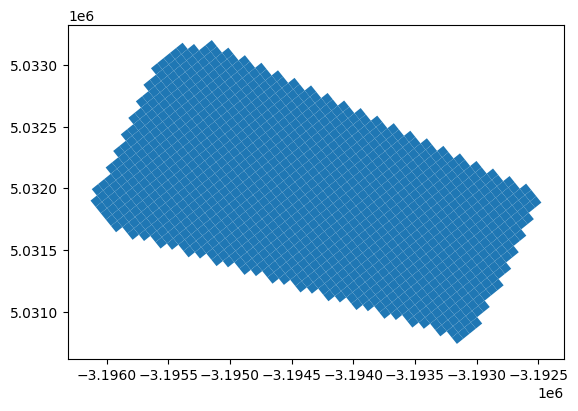

In [58]:
import geopandas as gpd
import numpy as np
from scipy.stats import linregress
import math

def estimar_inclinacion(grid):
    # Calcular los centroides de cada geometría en la grilla
    centroides = grid.geometry.centroid

    # Extraer las coordenadas x e y de los centroides
    x = centroides.x
    y = centroides.y

    # Realizar una regresión lineal
    regresion = linregress(x, y)

    # Calcular el ángulo de inclinación en radianes
    angulo_radianes = np.arctan(regresion.slope)

    # Convertir el ángulo a grados
    angulo_grados = np.degrees(angulo_radianes)

    return angulo_grados

angulo = estimar_inclinacion(grid)
print(f"Ángulo de inclinación: {angulo} grados")

rotated_gdf = rotate_gdf(grid, -angulo)
rotated_gdf.plot()

In [78]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def contar_pixeles_blancos(imagen):
    # Convertir la imagen a un array de numpy
    data = np.array(imagen)

    # Ignorar el canal alfa si está presente
    if data.shape[-1] == 4:
        data = data[:, :, :3]

    # Contar todos los píxeles que son blancos
    return np.sum(np.all(data == [255, 255, 255], axis=-1))


import pandas as pd

def encontrar_angulo_optimo(gdf, rango_angulos):
    angulo_optimo = None
    min_pixeles_blancos = float('inf')
    resultados = []

    for angulo in rango_angulos:
        # Rotar el GeoDataFrame
        gdf_rotado = rotate_gdf(gdf, angulo)

        # Generar y guardar el plot
        fig, ax = plt.subplots()
        gdf_rotado.plot(ax=ax)
        plt.axis('off')
        plt.savefig('temp_plot.png', bbox_inches='tight')
        plt.close(fig)

        # Cargar la imagen y contar los píxeles blancos
        imagen = Image.open('temp_plot.png')
        pixeles_blancos = contar_pixeles_blancos(imagen)
        pixeles_colores = imagen.size[0] * imagen.size[1] - pixeles_blancos

        # Actualizar el DataFrame con los resultados
        resultados.append(
            {'q_whites': pixeles_blancos, 
            'q_colors': pixeles_colores, 
            'angle': angulo}
        )

        if pixeles_blancos < min_pixeles_blancos:
            min_pixeles_blancos = pixeles_blancos
            angulo_optimo = angulo

    resultados = pd.DataFrame(resultados)
    return {'angulo_optimo': angulo_optimo, 'df': resultados}


In [ ]:
# Uso de la función
angulo = encontrar_angulo_optimo(gdf, range(-45, -20))

<Axes: xlabel='angle'>

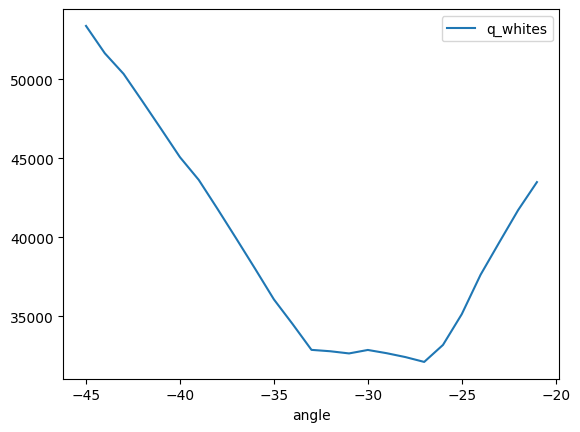

In [82]:
angulo['df'].plot(x='angle', y='q_whites')

<Axes: xlabel='angle'>

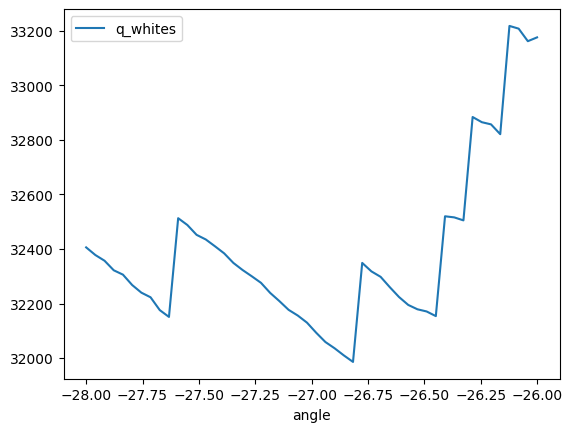

In [84]:
# Uso de la función
angulo_fino = encontrar_angulo_optimo(gdf, np.linspace(-28, -26))
angulo_fino['df'].plot(x='angle', y='q_whites')

In [85]:
angulo_fino['angulo_optimo']

-26.816326530612244

In [87]:
gdf_rotado = rotate_gdf(gdf, angulo_fino['angulo_optimo'])

In [91]:
import geopandas as gpd
from shapely.geometry import Point

def obtener_esquinas_gdf(gdf):
    # Calcular el bounding box total del GeoDataFrame
    total_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

    # Crear puntos para cada esquina
    puntos_esquinas = [
        Point(total_bounds[0], total_bounds[1]),  # Inferior Izquierda
        Point(total_bounds[2], total_bounds[1]),  # Inferior Derecha
        Point(total_bounds[0], total_bounds[3]),  # Superior Izquierda
        Point(total_bounds[2], total_bounds[3])   # Superior Derecha
    ]

    # Crear un GeoDataFrame para las esquinas
    esquinas_gdf = gpd.GeoDataFrame(geometry=puntos_esquinas, columns=['geometry'])
    return esquinas_gdf

# gdf_rotado = ... # Tu GeoDataFrame rotado
esquinas_gdf = obtener_esquinas_gdf(gdf_rotado)


In [109]:
import matplotlib.pyplot as plt

def plot_gdf_y_esquinas(gdf_rotado, esquinas_gdf=None):
    if(esquinas_gdf is None):
        esquinas_gdf = obtener_esquinas_gdf(gdf_rotado)
    fig, ax = plt.subplots()
    gdf_rotado.plot(ax=ax, color='blue', edgecolor='k')  # Plot del GeoDataFrame rotado
    esquinas_gdf.plot(ax=ax, color='red', marker='o')    # Plot de las esquinas

    # Opcional: Ajustar los límites y aspecto del plot
    ax.set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()


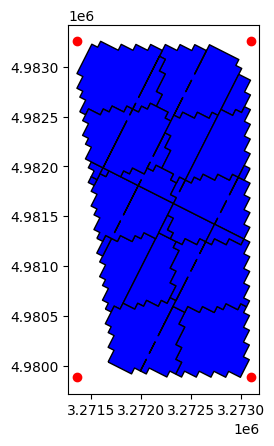

In [115]:
import geopandas as gpd
from shapely.ops import unary_union
import numpy as np
from sklearn.cluster import KMeans

def subsamplear_grilla(gdf, n_clusters):
    # Calcular los centroides de cada geometría
    centroides = gdf.geometry.centroid

    # Utilizar KMeans para agrupar los centroides
    kmeans = KMeans(n_clusters=n_clusters)
    centroides_coords = np.array(list(zip(centroides.x, centroides.y)))
    kmeans.fit(centroides_coords)
    labels = kmeans.labels_

    # Asignar cada geometría a un grupo
    gdf['grupo'] = labels

    # Combinar las geometrías en cada grupo
    grupos_combinados = gdf.groupby('grupo')['geometry'].apply(lambda x: unary_union(x.tolist()))

    # Crear un nuevo GeoDataFrame con las geometrías combinadas
    gdf_subsampleado = gpd.GeoDataFrame(geometry=grupos_combinados)
    return gdf_subsampleado

# Configura el número de clusters según tu grilla
n_clusters = 10 # Ajusta este número según sea necesario

# gdf = ... # Tu GeoDataFrame original
gdf_subsampleado = subsamplear_grilla(gdf_rotado, n_clusters)
plot_gdf_y_esquinas(gdf_subsampleado)

In [116]:
def calcular_dimensiones_promedio(gdf):
    largos = []
    anchos = []

    for geom in gdf.geometry:
        minx, miny, maxx, maxy = geom.bounds
        largo = maxy - miny
        ancho = maxx - minx
        largos.append(largo)
        anchos.append(ancho)

    largo_promedio = sum(largos) / len(largos)
    ancho_promedio = sum(anchos) / len(anchos)

    return largo_promedio, ancho_promedio

largo_promedio, ancho_promedio = calcular_dimensiones_promedio(gdf_rotado)

In [124]:
from shapely.geometry import Polygon

def generar_nueva_grilla(gdf, largo, ancho):
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    cuadriculas = []

    # Ajustar el tamaño de las cuadrículas al doble del promedio
    largo *= 2
    ancho *= 2

    # Crear cuadrículas
    x_min, y_min, x_max, y_max = bounds
    x = x_min
    while x < x_max:
        y = y_min
        while y < y_max:
            cuadricula = Polygon([(x, y), (x + ancho, y), (x + ancho, y + largo), (x, y + largo)])
            cuadriculas.append(cuadricula)
            y += largo
        x += ancho

    grilla_nueva = gpd.GeoDataFrame(geometry=cuadriculas)
    return grilla_nueva

grilla_nueva = generar_nueva_grilla(gdf_rotado, largo_promedio, ancho_promedio)

KeyboardInterrupt: 

In [ ]:
def cruce_espacial(gdf_original, gdf_nueva):
    cruce = gpd.overlay(gdf_original, gdf_nueva, how='intersection')
    return cruce

cruce = cruce_espacial(gdf_rotado, grilla_nueva)

<Axes: >

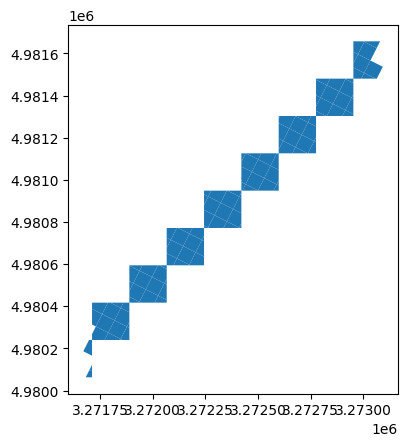

In [ ]:
cruce.plot()